In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import imageio

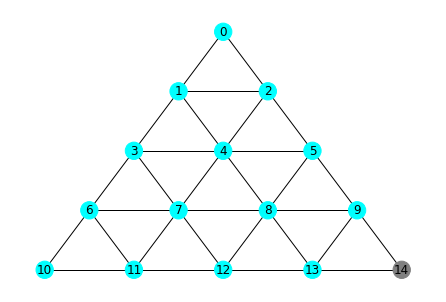

In [18]:
first_id_in_row = lambda row: sum(range(row+1))
height = 5
initial_empty = [14]
graph = nx.Graph()
graph_labels = {}
positions = {}
initial_config = {}
graph_colors = {'empty': 'grey', 'filled': 'cyan', 'moving':'orange', 'skipped':'red'}
for row in range(height+1):
    for col in range(row):
        idx = sum(range(row)) + col
        graph_labels[idx] = str(idx)
        positions[idx] = ((col-(height+row)/2)*5, (height-row)*5)
        graph.add_node(idx)
        initial_config[idx] = 'filled'
        if col < row-1:
            graph.add_edge(idx, idx+1, typeof='lateral')
        if row < height:
            graph.add_edge(idx, idx+row, typeof='vertical_fwd')
            graph.add_edge(idx, idx+row+1, typeof='vertical_back')
for i in initial_empty:
    initial_config[i] = 'empty'
nx.draw(graph, labels = graph_labels, pos=positions, node_color=[graph_colors[initial_config[peg]] for peg in initial_config])

In [13]:
[graph_colors[initial_config[peg]] for peg in initial_config]

['cyan',
 'cyan',
 'cyan',
 'cyan',
 'grey',
 'cyan',
 'cyan',
 'grey',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan']

In [27]:
def get_empty(configuration):
  return [key for key, val in configuration.items() if val == 'empty']


class Board:
    def __init__(self, config, move = None):
        self.data = config
        self.children = []
        self.move = move

    def get_possibles(self):
        current_config = self.data.copy()
        for empty_node in get_empty(self.data):
            print('assessing empty node {}'.format(empty_node))
            for neighbor in graph.neighbors(empty_node):
                print('\tlooking at neighbor (node {})'.format(neighbor))
                if self.data[neighbor] == 'filled':
                    for second_degree_neighbor in filter(lambda x: x != empty_node, graph.neighbors(neighbor)):
                        if graph.get_edge_data(neighbor, second_degree_neighbor)['typeof'] == graph.get_edge_data(neighbor, empty_node)['typeof'] and self.data[second_degree_neighbor] == 'filled':
                            current_config.update({second_degree_neighbor:'moving'})
                            break
        return current_config

    def generate_children(self):
        for empty_node in get_empty(self.data):
            for neighbor in graph.neighbors(empty_node):
                if self.data[neighbor] == 'filled':
                    for second_degree_neighbor in filter(lambda x: x != empty_node, graph.neighbors(neighbor)):
                        if graph.get_edge_data(neighbor, second_degree_neighbor)['typeof'] ==graph.get_edge_data(neighbor, empty_node)['typeof'] and self.data[second_degree_neighbor] == 'filled':
                            self.make_child({**self.data, **{empty_node:'filled', neighbor:'empty', second_degree_neighbor:'empty'}}, (second_degree_neighbor, neighbor, empty_node))
                            break

    def make_child(self, config, move = None):
        self.children.append(Board(config, move))

    def get_children(self):
        return self.children

    def count_children(self):
        return len(self.children)

    def score(self):
        return sum(range(height+1)) - len(get_empty(self.data))
    def __str__(self):
        return str(self.data)



def dfs_peg(root:(Board), best_score_ref, best_path_ref, path = []):
    if root.score() < best_score_ref[0]:
        print('Score: {}! UPDATING REF'.format(root.score()))
        best_score_ref[0] = root.score()
        best_path_ref[0] = path
    root.generate_children()
    branch = 0
    if root.score() == 1:
        return path
    for child in root.get_children():
        child_result = dfs_peg(child, best_score_ref, best_path_ref, path + [branch])
        if child_result:
            return child_result
        branch = branch+1
    return False

def print_winning_moves(root:(Board), child_choices:list[int]):
    for child_idx in child_choices:
        root = root.get_children()[child_idx]
        print(child_idx)

def get_winning_moves(root:(Board), child_choices:list[int]):
    moves = []
    print('children: {}'.format(child_choices))
    for child_idx in child_choices:
        root = root.get_children()[child_idx]
        moves.append(root.move)
    return moves


In [28]:
initial_board = Board(initial_config)
best_score = [len(initial_config)]
best_performance = [[]]
child_chain = dfs_peg(initial_board, best_score, best_performance)
winning_moves = None
if child_chain:
    winning_moves = get_winning_moves(initial_board, child_chain)
else:
    winning_moves = get_winning_moves(initial_board, best_performance[0])

Score: 13! UPDATING REF
Score: 12! UPDATING REF
Score: 11! UPDATING REF
Score: 10! UPDATING REF
Score: 9! UPDATING REF
Score: 8! UPDATING REF
Score: 7! UPDATING REF
Score: 6! UPDATING REF
Score: 5! UPDATING REF
Score: 4! UPDATING REF
Score: 3! UPDATING REF
Score: 2! UPDATING REF
children: [0, 0, 0, 2, 2, 0, 3, 0, 1, 0, 0]


In [29]:
def generate_winning_graphic(move_list, config, graphic_name, turn = 1):
    from_node, skip_node, to_node = move_list[0]
    config.update({from_node:'moving'})
    nx.draw(graph, pos=positions, node_color=[graph_colors[config[node]] for node in graph.nodes()])
    plt.savefig('{}/Turn {:02d} - Phase {}'.format(graphic_name, turn, 1))
    plt.clf()
    config.update({from_node:'empty', skip_node:'skipped', to_node:'moving'})
    nx.draw(graph, pos=positions, node_color=[graph_colors[config[node]] for node in graph.nodes()])
    plt.savefig('{}/Turn {:02d} - Phase {}'.format(graphic_name, turn, 2))
    plt.clf()
    config.update({skip_node:'empty', to_node:'filled'})
    nx.draw(graph, pos=positions, node_color=[graph_colors[config[node]] for node in graph.nodes()])
    plt.savefig('{}/Turn {:02d} - Phase {}'.format(graphic_name, turn, 3))
    plt.clf()
    print('turn {} done!'.format(turn))
    if len(move_list) > 1:
        generate_winning_graphic(move_list[1:], config, graphic_name, turn+1)

In [30]:
graphic_name = 'winning_moves'
output_path = Path.cwd().joinpath(graphic_name)
output_path.mkdir(parents=True, exist_ok=True)
generate_winning_graphic(winning_moves, initial_config, graphic_name)

turn 1 done!
turn 2 done!
turn 3 done!
turn 4 done!
turn 5 done!
turn 6 done!
turn 7 done!
turn 8 done!
turn 9 done!
turn 10 done!
turn 11 done!


<Figure size 432x288 with 0 Axes>

In [32]:
file_list = sorted(output_path.glob('*.png'))
frames = []
for file in file_list:
    print(file)
    frames.append(imageio.imread(file))
imageio.mimsave('output.gif', frames, duration = 0.75)

/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 01 - Phase 1.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 01 - Phase 2.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 01 - Phase 3.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 02 - Phase 1.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 02 - Phase 2.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 02 - Phase 3.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 03 - Phase 1.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 03 - Phase 2.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 03 - Phase 3.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 04 - Phase 1.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 04 - Phase 2.png
/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 04 - Phase 3.png
/Users/omzooz/Documents/projects/peg-sol

In [31]:
file_list

[PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 01 - Phase 1.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 01 - Phase 2.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 01 - Phase 3.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 02 - Phase 1.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 02 - Phase 2.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 02 - Phase 3.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 03 - Phase 1.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 03 - Phase 2.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 03 - Phase 3.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-solver/winning_moves/Turn 04 - Phase 1.png'),
 PosixPath('/Users/omzooz/Documents/projects/peg-s